# New notebook

In [1]:
import os

# standard libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF

# image processing
from skimage import io
from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_li
from skimage.measure import find_contours

# custom library
from devenw.plot import plot_dimred, plot_acts, plot_corr, plot_eigenspec
from devenw.compute import fit_pca, fit_tsne, fit_tsne_1d, fit_kmeans, prepare_data, fit_rmap_1d
from devenw.nmf import downsample_tiff_avg, plot_nmf_t, plot_nmf_px

# going to root of devenw
os.chdir('..')

# reload code if library changes
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
# defining analysis parameters
ds = 'ani98_XXXX-XX-XX_a'

n_components = 20
blur_std = 6.5
downs_fact = 1 # keep as 1 for no downsampling
resolution = 1.2 # in um 

In [3]:
# defining functions
def get_thr_img_auto(loading_img, blur_std, i, axs):

    loading_img_filt = gaussian_filter(loading_img, blur_std)

    auto_thresh = threshold_li(loading_img_filt)

    roi = loading_img_filt > auto_thresh
    
    axs[i,0].imshow(loading_img)
    axs[i,1].imshow(loading_img_filt)
    axs[i,2].imshow(roi) # arbitrary threshold

    axs[i,0].axis('off')
    axs[i,1].axis('off')
    axs[i,2].axis('off')
    
    axs[i,0].set_xlabel(f'NMF{i+1}', fontsize=100)
    
    if i == 0:
        
        axs[i,0].set_title('NMF', fontsize=5)
        axs[i,1].set_title('Gaussian blur', fontsize=5)
        axs[i,2].set_title('Thresholded (Li)', fontsize=5)

    return roi

file000_chan0.tif
(500, 405, 405)
file001_chan0.tif
(500, 405, 405)
(1000, 405, 405)
file002_chan0.tif
(500, 405, 405)
(1500, 405, 405)
file003_chan0.tif
(500, 405, 405)
(2000, 405, 405)
file004_chan0.tif
(500, 405, 405)
(2500, 405, 405)
file005_chan0.tif
(500, 405, 405)
(3000, 405, 405)
file006_chan0.tif
(500, 405, 405)
(3500, 405, 405)
file007_chan0.tif
(100, 405, 405)
(3600, 405, 405)
Shape of video: (3600, 405, 405)


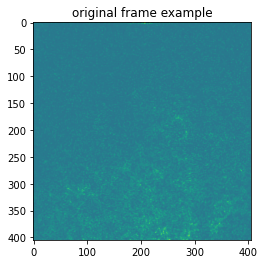

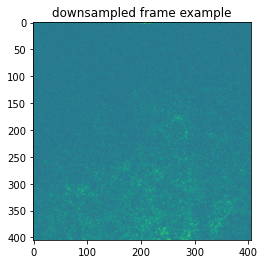

Shape of re_shaped video: (3600, 164025)


In [4]:
# get list of tiffs
tiff_all = []
for (i, ti) in enumerate(os.listdir(f'data/{ds}/suite2p/plane0/reg_tif')):
    print(ti)
    if i == 0:
        tiff = io.imread(f'data/{ds}/suite2p/plane0/reg_tif/{ti}',  plugin='pil') # initialise tiff
    else:
        tiff_i = io.imread(f'data/{ds}/suite2p/plane0/reg_tif/{ti}',  plugin='pil')
        tiff = np.concatenate((tiff, tiff_i))
        print(tiff_i.shape)
    print(tiff.shape)

# making sure smallest value of tiff is zero - just a linear transform, shouldn't affect NMF
tiff -= np.min(tiff)
        

print(f'Shape of video: {tiff.shape}') 
n_frames = tiff.shape[0] 
x_axis = tiff.shape[1]
y_axis = tiff.shape[2]

# downsample for cross-validation # IMPORTANT: downsampling will mean fewer components are significant (but same goes for imaging at lower res.)
tiff =downsample_tiff_avg(tiff, n=downs_fact)

tiff_flat = np.reshape(tiff, (n_frames, tiff.shape[1]*tiff.shape[2]))
print(f'Shape of re_shaped video: {tiff_flat.shape}') 

# NMF on pixels

In [5]:
#initialising nmf and fitting to pixels
nmf_px = NMF(n_components=n_components)
nmf_px.fit(tiff_flat)

C:\Users\majnik\Miniconda3\envs\deve-networks\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\majnik\Miniconda3\envs\deve-networks\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=20)

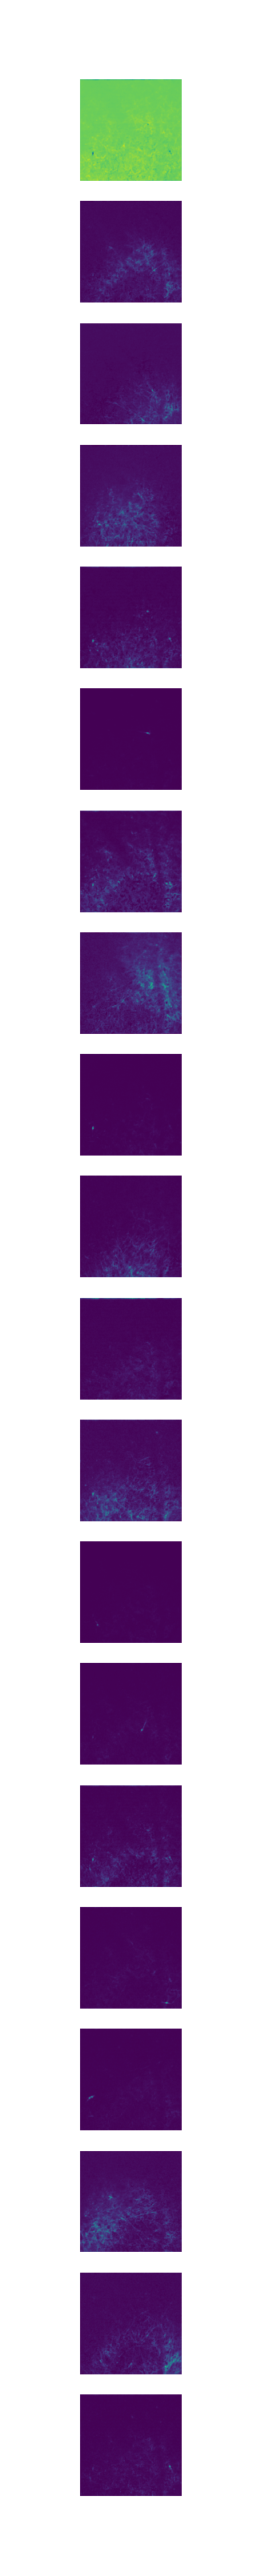

In [6]:
plot_nmf_px(nmf_px, tiff.shape[1])

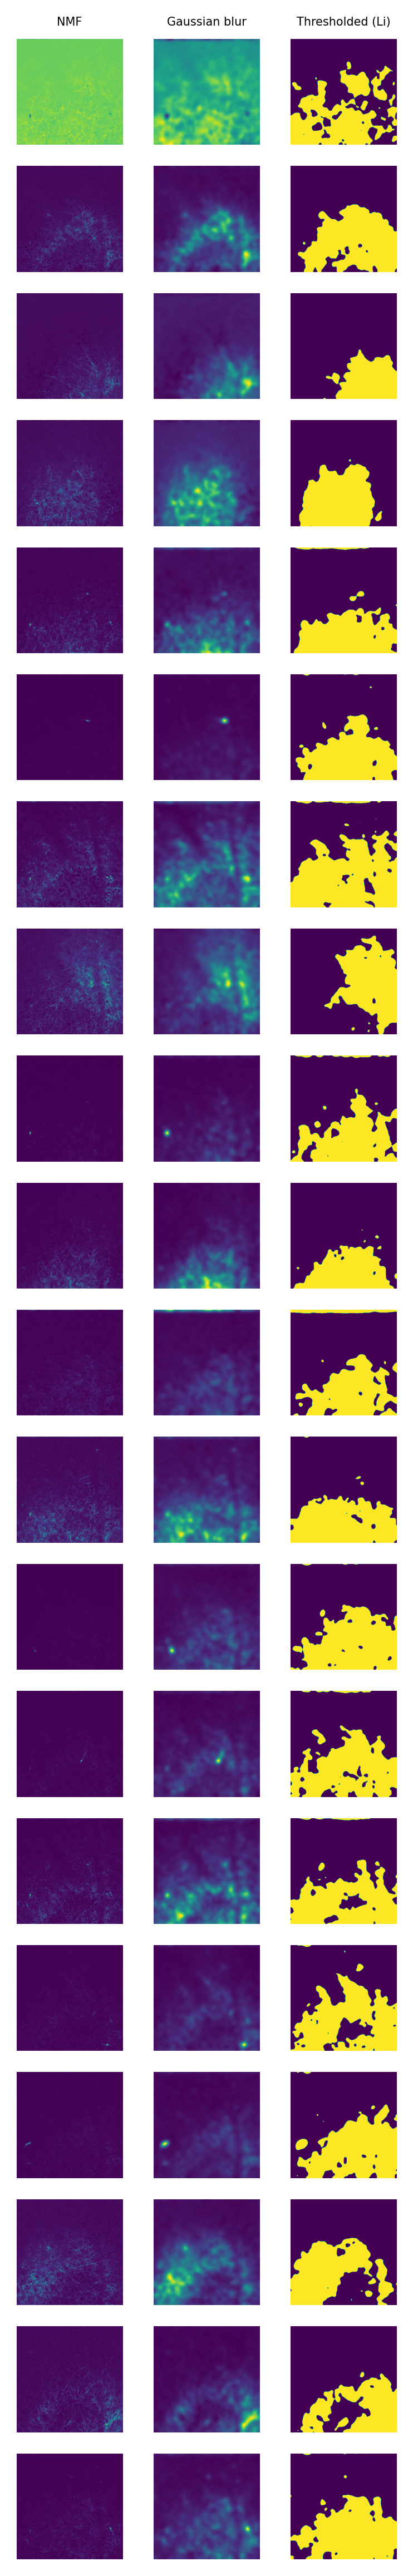

In [7]:
# thresholding and defining auto rois
fig, axs = plt.subplots(n_components, 3, dpi=300, figsize=(3,n_components))

loading_imgs = []
rois_auto = []

for i in range(n_components):
    
    loading = nmf_px.components_[i,:] # attr of nmf object
    loading_img = loading.reshape(x_axis, y_axis) #reshape ith nmf
    roi_auto = get_thr_img_auto(loading_img, blur_std, i,axs) #blur and thresh
    
    loading_imgs.append(loading_img)
    rois_auto.append(roi_auto) #add it to the list, fisrt iteration list is empty, after second iteration 1 nmf gets into teh lsit as threshloded matrix pf t and f


In [8]:
# plotting all rois overlapped (issue: big rois might overlap and hide smaller ones)
# plt.figure(figsize=(10,10))

# for (i, roi) in enumerate(reversed(rois_auto)): # reversed to plot more obvious components first
#     roi_scat = np.nonzero(roi)
#     plt.scatter(roi_scat[1], -roi_scat[0], marker='s', s=9, alpha=0.1) # - is because of image processing convention
#     plt.ylim((-y_axis, 0))
#     plt.xlim((0,x_axis))
#     plt.axis('off')
# plt.show()

In [9]:
# setting (and optionally creating) save path
save_path = os.getcwd() + '/data/' + ds + '/patch_sz/'

if not os.path.isdir(save_path):
    os.mkdir(save_path)
    
print('SavePath: ', save_path)

SavePath:  E:\deve-networks/data/ani98_XXXX-XX-XX_a/patch_sz/


In [10]:
# plotting 'single patch' roi outlines and exporting for imageJ/fiji
plt.figure(figsize=(10,10))

conts = []
n_conts = []
rois_auto_single = []
rois_auto_single_inds = []


for (i, roi) in enumerate(rois_auto):
    
    # roi_bounds = np.absolute(np.gradient(roi.astype(int), axis=0))
    # roi_scat = np.nonzero(roi_bounds)
    
    roi_cont = find_contours(roi)
    conts.append(roi_cont)
    n_conts.append(len(roi_cont))
    
    if len(roi_cont) == 1: # this now only chooses single continuous roi patches! but could also run an inner loop for multi-contour rois
        
        rois_auto_single.append(roi)
        rois_auto_single_inds.append(i)
        
        plt.plot(roi_cont[0][:,1], roi_cont[0][:,0], linewidth=5, alpha=0.7)
    
        plt.ylim((y_axis, 0))
        plt.xlim((0,x_axis))
        plt.axis('off')
        
        with open(save_path + f'nmf{i+1}_roi.txt', 'w') as f:
            for j in range(len(roi_cont[0])):
                f.write(f'{roi_cont[0][j,1]}    {roi_cont[0][j,0]}\n')



<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'number of patches in nmf component')

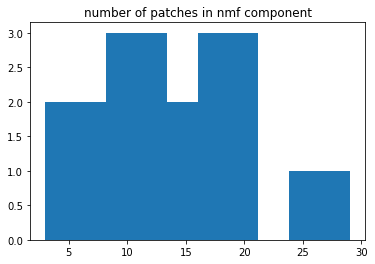

In [11]:
plt.hist(n_conts)
plt.title('number of patches in nmf component')

In [12]:
# computing areas of patches and plotting distribution
roi_areas = [np.sum(roi)*(resolution**2) for roi in rois_auto]

Text(0.5, 0, 'area (um^2)')

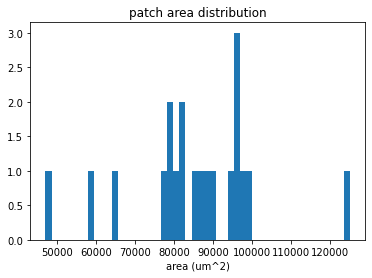

In [13]:
plt.hist(roi_areas, 50);
plt.title('patch area distribution')
plt.xlabel('area (um^2)')

Text(0.5, 0, 'area (um^2)')

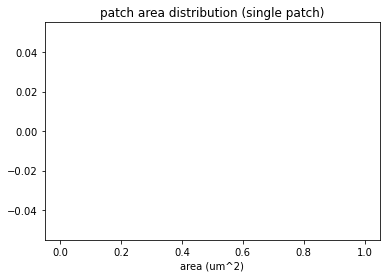

In [14]:
# computing areas of patches and plotting distribution
roi_areas_single = [np.sum(roi)*(resolution**2) for roi in rois_auto_single]
plt.hist(roi_areas_single,15);
plt.title('patch area distribution (single patch)')
plt.xlabel('area (um^2)')

In [15]:
print('Proportion of single to multi roi components:', len(roi_areas_single)/len(roi_areas))

Proportion of single to multi roi components: 0.0


Text(0.5, 1.0, 'area/component scatter (single patch)')

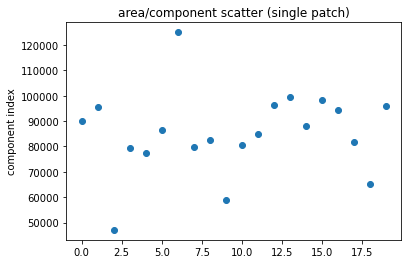

In [16]:
plt.scatter(range(len(roi_areas)), roi_areas)
plt.ylabel('ROI area')
plt.ylabel('component index')
plt.title('area/component scatter (single patch)')

Text(0.5, 1.0, 'area/component scatter (single patch)')

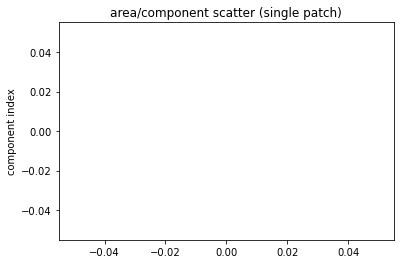

In [17]:
plt.scatter(rois_auto_single_inds, roi_areas_single)
plt.ylabel('ROI area')
plt.ylabel('component index')
plt.title('area/component scatter (single patch)')

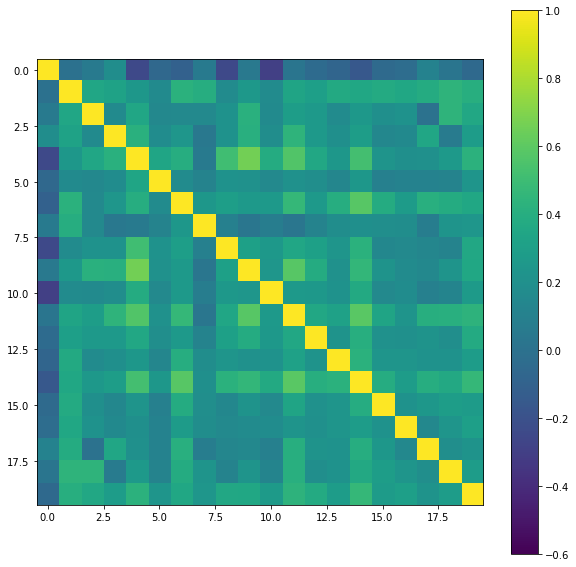

In [18]:
# looking at correlation (in the binary case this is equivalent to the percentage of overlap)
plt.figure(figsize=(10,10))
nmf_px_corrmat = np.corrcoef(nmf_px.components_) # correlation matrix of this
plt.imshow(nmf_px_corrmat, vmin=-0.6, vmax=1)
plt.colorbar() 

C:\Users\majnik\AppData\Local\Temp\ipykernel_19964\90216020.py:4: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(nmf_px_corrmat)
C:\Users\majnik\AppData\Local\Temp\ipykernel_19964\90216020.py:4: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(nmf_px_corrmat)


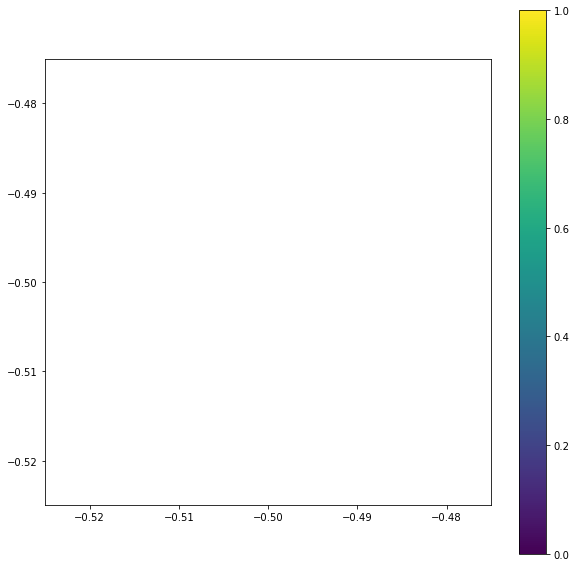

In [19]:
# looking at correlation (in the binary case this is equivalent to the percentage of overlap)
plt.figure(figsize=(10,10))
nmf_px_corrmat = np.corrcoef(nmf_px.components_[rois_auto_single_inds, :]) # correlation matrix of this
plt.imshow(nmf_px_corrmat)
plt.colorbar()

# NMF on time

In [20]:
# Initialising nmf and fitting to time
nmf_t = NMF(n_components=n_components)
nmf_t.fit(tiff_flat.T)

C:\Users\majnik\Miniconda3\envs\deve-networks\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\majnik\Miniconda3\envs\deve-networks\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=20)

In [21]:
## saving all temporal components to list:
loading_times = []

for i in range(n_components):
    loading_time = nmf_t.components_[i, :]
    loading_times.append(loading_time)

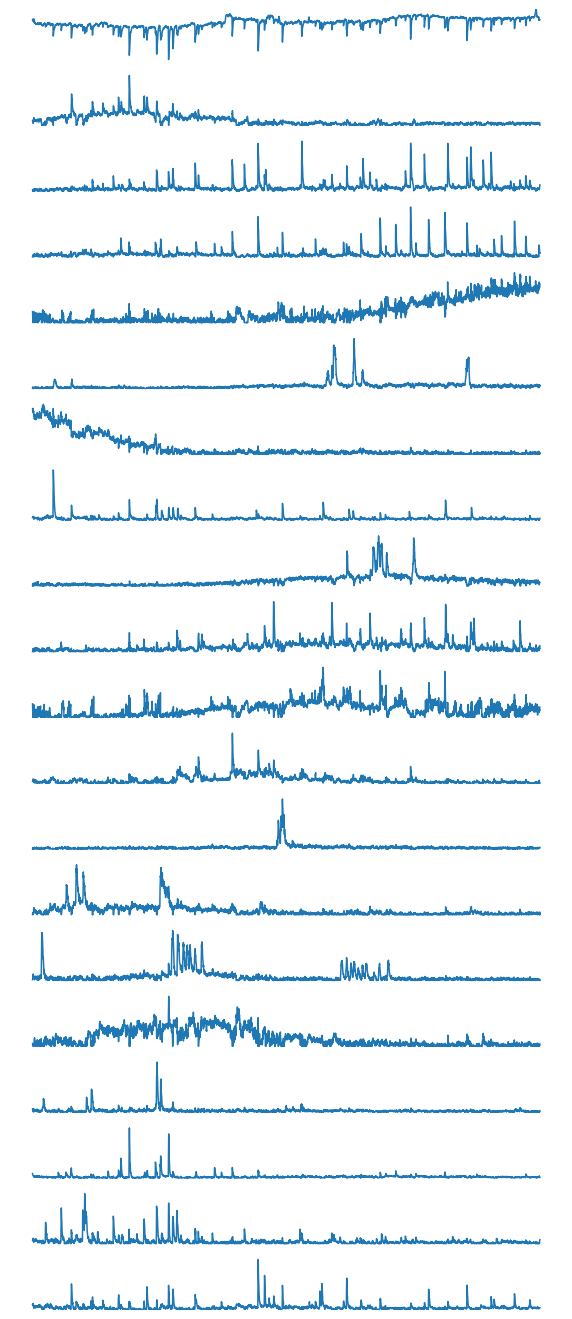

In [22]:
# plotting how components (patches) get activated over time
fig, axs = plt.subplots(n_components, 1, figsize=(10,24))

for (i, loading_time) in enumerate(loading_times):
    axs[i].plot(loading_time)
    axs[i].axis('off')

plt.show()
    
    

# Saving variables

In [23]:
# variables to save:
tiff_dimred_exp = {'loading_imgs': loading_imgs,
                   'loading_times': loading_times,
                   'rois_auto': rois_auto,
                   'conts': conts,
                   'roi_areas': roi_areas}

In [24]:
np.save(f'{save_path}/export_tiff_dimred.npy', tiff_dimred_exp, allow_pickle=True)